## Examining the relationship between crude oil prices and gasoline prices

In [1]:
import os
import requests
import pandas as pd
from pandas.tseries.offsets import DateOffset
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import statsmodels.api as sm
import numpy as np
import pymc3 as pm
import json
import arviz as az


WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
eia_api_key = os.environ['EIA_API_KEY']

### Querying EIA daily WTI crude oil prices
series name:   Cushing, OK WTI Spot Price FOB, Daily

series ID:     PET.RWTC.D

url:           https://www.eia.gov/opendata/qb.php?sdid=PET.RWTC.D

In [3]:
wti_api_url = r'https://api.eia.gov/series/?api_key=' + eia_api_key + '&series_id=PET.RWTC.D'
response = requests.get(wti_api_url)
wti = response.json()
df_wti = pd.DataFrame(wti['series'][0]['data'])
df_wti.rename(columns={0: 'date', 1: 'wti'}, inplace=True)
df_wti['date'] = pd.to_datetime(df_wti.date)
df_wti.sort_values(by='date', inplace=True)
df_wti.tail()

,date,wti
4,2022-03-08,123.64
3,2022-03-09,108.81
2,2022-03-10,105.93
1,2022-03-11,109.31
0,2022-03-14,103.22


### Querying EIA weekly gasoline prices
series name:   U.S. All Grades All Formulations Retail Gasoline Prices, Weekly

series ID:     PET.EMM_EPM0_PTE_NUS_DPG.W

url:           https://www.eia.gov/opendata/qb.php?sdid=PET.EMM_EPM0_PTE_NUS_DPG.W

In [4]:
gasoline_api_url = r'https://api.eia.gov/series/?api_key=' + eia_api_key + '&series_id=PET.EMM_EPM0_PTE_NUS_DPG.W'
response = requests.get(gasoline_api_url)
gasoline = response.json()
df_gasoline = pd.DataFrame(gasoline['series'][0]['data'])
df_gasoline.rename(columns={0: 'date', 1: 'gasoline'}, inplace=True)
df_gasoline['date'] = pd.to_datetime(df_gasoline.date)
df_gasoline.sort_values(by='date', inplace=True)
df_gasoline.tail()

,date,gasoline
4,2022-02-14,3.581
3,2022-02-21,3.624
2,2022-02-28,3.701
1,2022-03-07,4.196
0,2022-03-14,4.414


Gasoline data is weekly but oil data is daily. We can write a function to average the daily oil prices over the corresponding week for gasoline prices.

In [5]:
def weekly_oil(df1, df2):
    wti_weekly = pd.DataFrame(columns=['date', 'wti'])
    wti_prices = []
    num_dates = len(df1.date.unique())
    for i, d in enumerate(df1.date.unique()):
        if i == 0:
            end = pd.Timestamp(d)
            start = end - DateOffset(days=7)
            wti_prices.append(df2.loc[(df2.date>start)&(df2.date<=end), 'wti'].mean())
        else:
            start = df1.date.iloc[i-1]
            end = d
            wti_prices.append(df2.loc[(df2.date>start)&(df2.date<=end), 'wti'].mean())
    wti_weekly['date'] = df1.date.unique()
    wti_weekly['wti'] = wti_prices
    return wti_weekly

df_wti_weekly = weekly_oil(df_gasoline, df_wti)

Combine both weekly datasets into a single dataframe for analysis. Also add a year column for good measure.

In [6]:
df = df_gasoline.merge(df_wti_weekly, on='date')
df['year'] = df.date.dt.year

### Let's plot

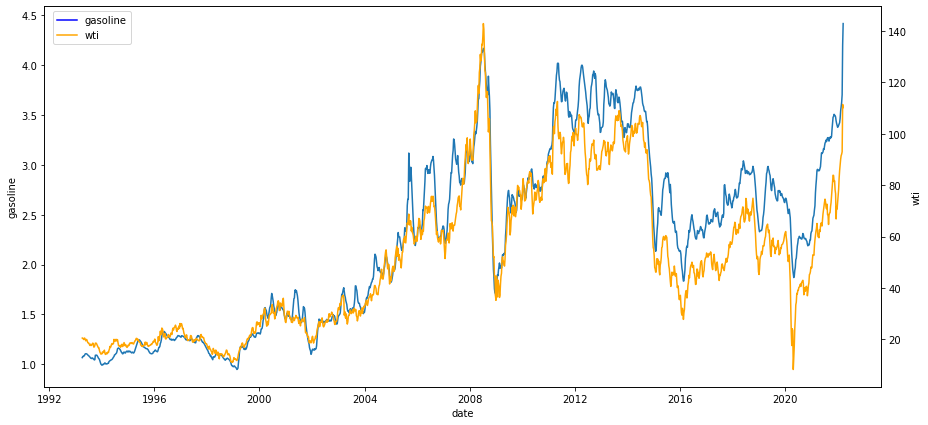

In [7]:
fig, ax1 = plt.subplots(figsize=(15,7))
ax2 = ax1.twinx()
g = sns.lineplot(data=df, x='date', y='gasoline', ax=ax1)
sns.lineplot(data=df, x='date', y='wti', ax=ax2, color='orange')
g.legend(handles=[Line2D([], [], color='blue', label='gasoline'),
                  Line2D([], [], color='orange', label='wti')], loc=(0.01,.9))
plt.savefig('wti and gasoline vs time.png')

This first plot is just weekly gasoline and oil prices vs time. The two series are clearly correlated, which makes sense.

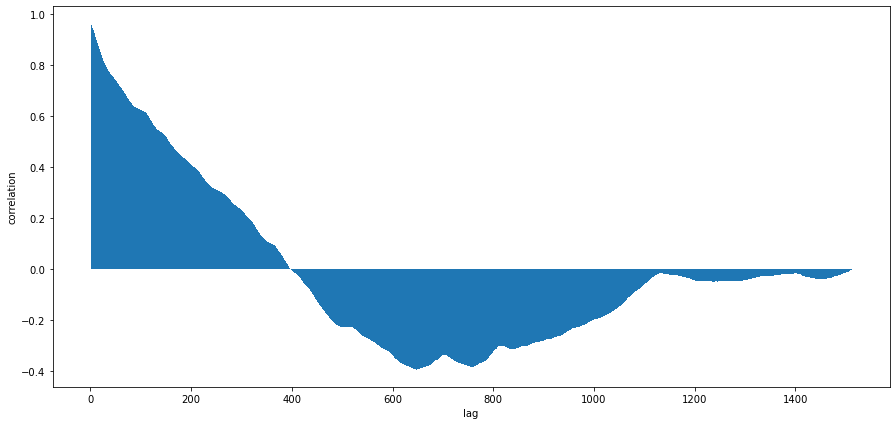

In [8]:
cross_corr = sm.tsa.stattools.ccf(df.wti, df.gasoline, adjusted=False)
fig, ax = plt.subplots(figsize=(15,7))
plt.bar(np.arange(1, len(df)+1), cross_corr, width=1)
plt.ylabel('correlation')
plt.xlabel('lag')
plt.savefig('wti vs gasoline cross correlation.png')

A common argument is that there is a multi-week lag between crude oil prices and what we see at the pump. In other words, if oil prices drop quickly, consumers won't see a change in gas prices for a few weeks. We can investigate that by evaluating the correlation between the two at different lags (where lag would be in number of weeks). Based on the plot below, the correlation drops with increasing lag suggesting that, at least with weekly data resolution, gasoline prices respond immediately with changes in oil prices.

Let's look at the crack spread, which is the difference in price between a refined petroleum product and the raw input product. In this case, we will define the crack spread as the difference between gasoline prices and crude oil prices. This margin would cover all refining, transportation, and marketing costs and profit to get oil at a refinery into gasoline in your tank.

In [9]:
df['gasoline_bbls'] = df.gasoline * 42
df['crack_spread'] = df.gasoline_bbls - df.wti
df.tail()

,date,gasoline,wti,year,gasoline_bbls,crack_spread
1506,2022-02-14,3.581,91.468,2022,150.402,58.934
1507,2022-02-21,3.624,92.040,2022,152.208,60.168
1508,2022-02-28,3.701,92.966,2022,155.442,62.476
1509,2022-03-07,4.196,111.424,2022,176.232,64.808
1510,2022-03-14,4.414,110.182,2022,185.388,75.206


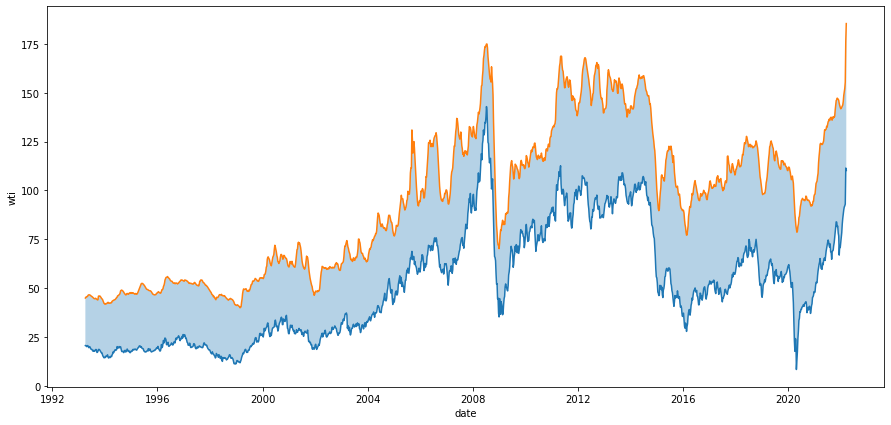

In [10]:
fig, ax1 = plt.subplots(figsize=(15,7))
sns.lineplot(data=df, x='date', y='wti')
sns.lineplot(data=df, x='date', y='gasoline_bbls')
plt.fill_between(df.date, df.wti, df.gasoline_bbls, alpha=0.33)

Plotting the margin over time as the shaded area between gasoline prices in \$/bbl and crude oil prices in \$/bbl

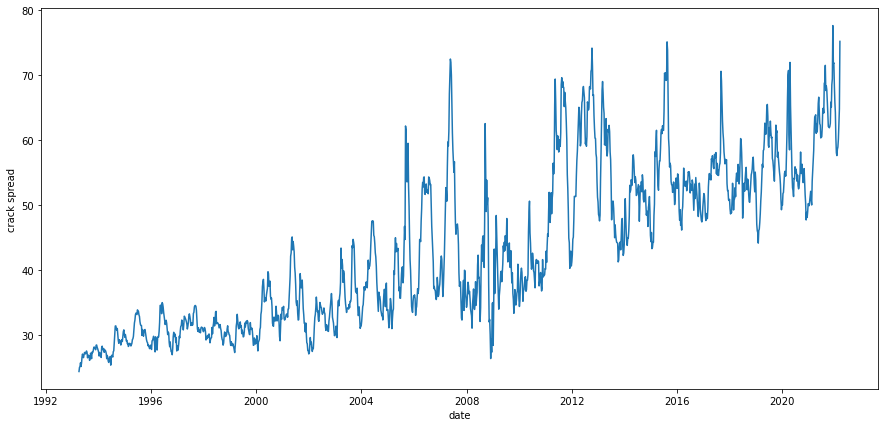

In [11]:

fig, ax1 = plt.subplots(figsize=(15,7))
g = sns.lineplot(data=df, x='date', y='crack_spread', ax=ax1)
plt.ylabel('crack spread')
plt.savefig('crack spread vs time.png')

Plotting the crack spread vs time shows a pretty clear upward trend and certainly suggests that profit margins are getting fatter.

But we have seen significant inflation over the years, so let's normalize the data set using a CPI from the BLS website.

series name:    Energy in U.S. city average, all urban consumers, not seasonally adjusted

series ID:      CUUR0000SA0E

url:            https://www.bls.gov/data/

The API for the BLS website only allows 10 years of data to be queried at a time, so we can manually piece separate queries together to match the oil and gasoline date range.

In [12]:
headers = {'Content-type': 'application/json'}
data = json.dumps({'seriesid':  ['CUUR0000SA0E'],
                   'startyear': '1992', 
                   'endyear':   '2001'})
p = requests.post('https://api.bls.gov/publicAPI/v1/timeseries/data/', data=data, headers=headers)
cpi_data1 = json.loads(p.text)
print(cpi_data1['status'])
print(cpi_data1['message'])

headers = {'Content-type': 'application/json'}
data = json.dumps({'seriesid':  ['CUUR0000SA0E'],
                   'startyear': '2002', 
                   'endyear':   '2011'})
p = requests.post('https://api.bls.gov/publicAPI/v1/timeseries/data/', data=data, headers=headers)
cpi_data2 = json.loads(p.text)
print(cpi_data2['status'])
print(cpi_data2['message'])

headers = {'Content-type': 'application/json'}
data = json.dumps({'seriesid':  ['CUUR0000SA0E'],
                   'startyear': '2012', 
                   'endyear':   '2021'})
p = requests.post('https://api.bls.gov/publicAPI/v1/timeseries/data/', data=data, headers=headers)
cpi_data3 = json.loads(p.text)
print(cpi_data3['status'])
print(cpi_data3['message'])

headers = {'Content-type': 'application/json'}
data = json.dumps({'seriesid':  ['CUUR0000SA0E'],
                   'startyear': '2022', 
                   'endyear':   '2022'})
p = requests.post('https://api.bls.gov/publicAPI/v1/timeseries/data/', data=data, headers=headers)
cpi_data4 = json.loads(p.text)
print(cpi_data4['status'])
print(cpi_data4['message'])

REQUEST_SUCCEEDED
[]
REQUEST_SUCCEEDED
[]
REQUEST_SUCCEEDED
[]
REQUEST_SUCCEEDED
[]


CPI data is provided monthly. We loop through each query, skip over the half-year values, strip the 'M' from the month, and convert the month value to an integer.

In [13]:
df_cpi = pd.DataFrame(columns=['year', 'period', 'value'])
year = []
period = []
value = []

for i in cpi_data1['Results']['series'][0]['data']:
    year.append(int(i['year']))
    if 'S' not in i['period']:
        period.append(int(i['period'].strip('M')))
    value.append(float(i['value']))

for i in cpi_data2['Results']['series'][0]['data']:
    year.append(int(i['year']))
    if 'S' not in i['period']:
        period.append(int(i['period'].strip('M')))
    value.append(float(i['value']))

for i in cpi_data3['Results']['series'][0]['data']:
    year.append(int(i['year']))
    if 'S' not in i['period']:
        period.append(int(i['period'].strip('M')))
    value.append(float(i['value']))

for i in cpi_data4['Results']['series'][0]['data']:
    year.append(int(i['year']))
    if 'S' not in i['period']:
        period.append(int(i['period'].strip('M')))
    value.append(float(i['value']))

df_cpi['year'] = year
df_cpi['period'] = period
df_cpi['value'] = value

We loop over the data and match up the year and month with the corresponding oil and gasoline date. Then we can divide gasoline, oil, and crack spread values by the CPI and multiply by 100 to normalize it to prices in the base period of 1982-1984.

In [14]:
cpi_values = []
for i, row in df.iterrows():
    year = row['year']
    month = row['date'].month
    cpi = df_cpi.loc[(df_cpi.year == year) & (df_cpi.period == month), 'value'].values
    if len(cpi) > 0:
        cpi_values.append(cpi[0])
    else:
        cpi_values.append(cpi_values[i-1])
df['cpi_values'] = cpi_values
df['crack_spread_adj'] = df.crack_spread / df.cpi_values * 100
df['gasoline_adj'] = df.gasoline / df.cpi_values * 100
df['gasoline_bbls_adj'] = df.gasoline_bbls / df.cpi_values * 100
df['wti_adj'] = df.wti / df.cpi_values * 100

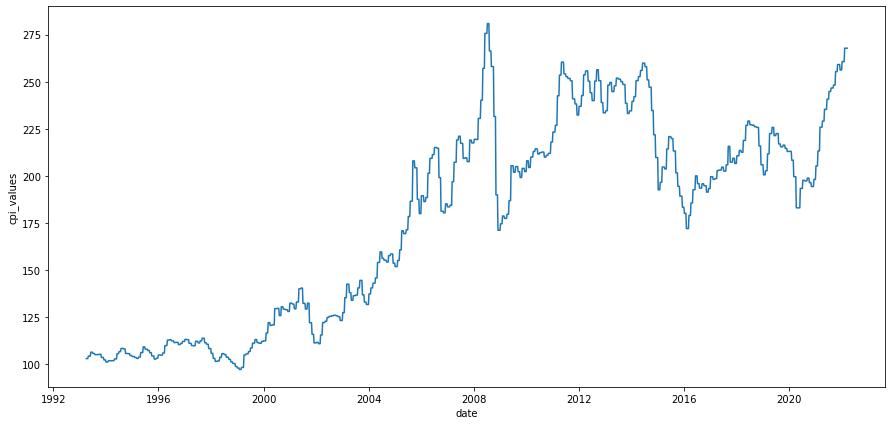

In [15]:
fig, ax1 = plt.subplots(figsize=(15,7))
g = sns.lineplot(data=df, x='date', y='cpi_values', ax=ax1)

The above plot shows the CPI value over time. Recent run up could be impacting gasoline prices.

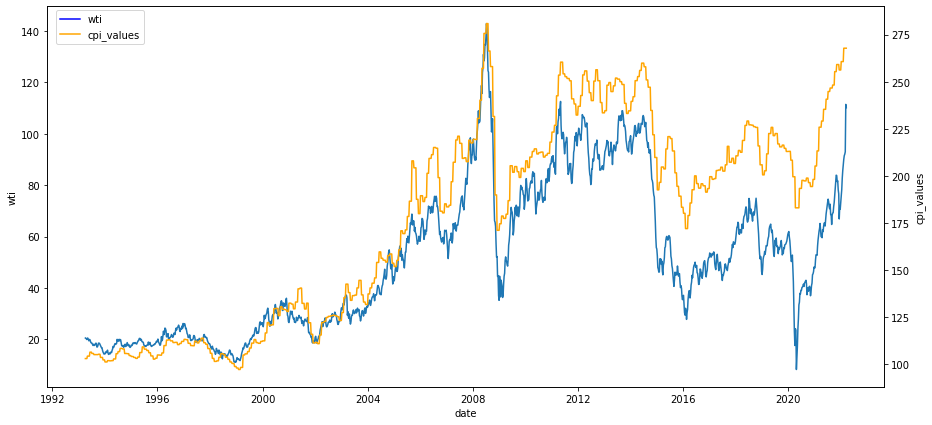

In [16]:
fig, ax1 = plt.subplots(figsize=(15,7))
ax2 = ax1.twinx()
g = sns.lineplot(data=df, x='date', y='wti', ax=ax1)
sns.lineplot(data=df, x='date', y='cpi_values', ax=ax2, color='orange')
g.legend(handles=[Line2D([], [], color='blue', label='wti'),
                  Line2D([], [], color='orange', label='cpi_values')], loc=(0.01,.9))
plt.savefig('wti and cpi vs time.png')

CPI vs oil price. I am using the energy index, so makes sense they are correlated.

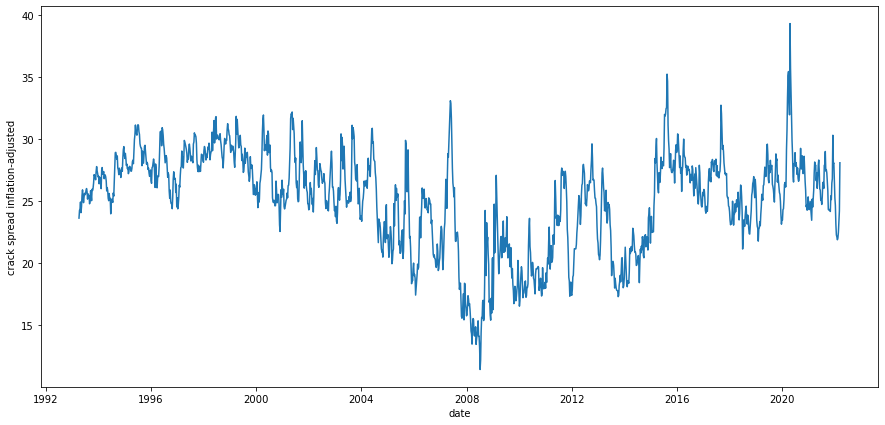

In [17]:
fig, ax1 = plt.subplots(figsize=(15,7))
g = sns.lineplot(data=df, x='date', y='crack_spread_adj', ax=ax1)
plt.ylabel('crack spread inflation-adjusted')
plt.savefig('crack spread adjusted vs time.png')

Plotting inflation-adjusted crack spread vs time looks quite different. The upward trend is gone; the margin remains relatively consistent over the past few decades.

Save the most recent data point to variables so we can annotate the next few plots.

In [18]:
last_date = pd.Timestamp(df.tail(1).date.values[0]).strftime('%m/%d/%Y')
xpos = df.tail(1).wti.values[0]
ypos = df.tail(1).gasoline.values[0]
xpos_adj = df.tail(1).wti_adj.values[0]
ypos_adj = df.tail(1).gasoline_adj.values[0]
ypos_bbls = df.tail(1).gasoline_bbls.values[0]
ypos_bbls_adj = df.tail(1).gasoline_bbls_adj.values[0]
ypos_cs_adj = df.tail(1).crack_spread_adj.values[0]

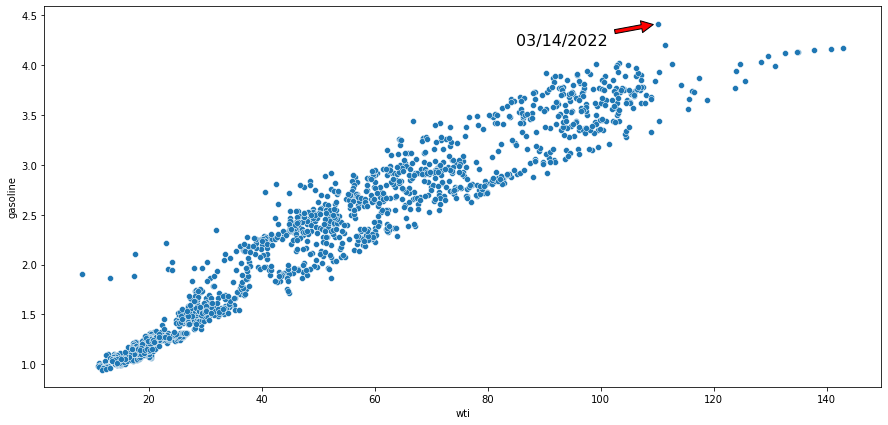

In [19]:
fig, ax = plt.subplots(figsize=(15,7))
sns.scatterplot(data=df, x='wti', y='gasoline')
plt.annotate(last_date, xy=(xpos, ypos), xytext=(85, 4.2),
            arrowprops=dict(facecolor='red', shrink=0.1), size=16)
plt.savefig('wti vs gasoline.png')

Gasoline is obviously dependent on oil prices, so let's look at that relationship by plotting gasoline prices vs oil prices. The arrow points to the most recent data.

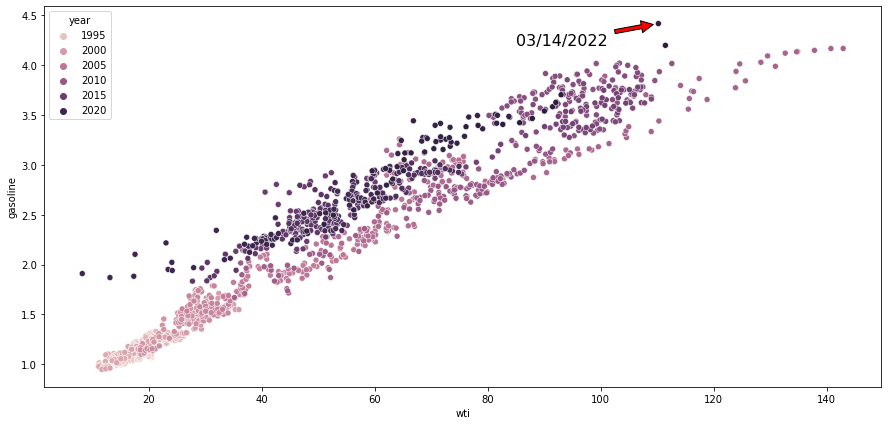

In [20]:
fig, ax = plt.subplots(figsize=(15,7))
sns.scatterplot(data=df, x='wti', y='gasoline', hue='year')
plt.annotate(last_date, xy=(xpos, ypos), xytext=(85, 4.2),
            arrowprops=dict(facecolor='red', shrink=0.1), size=16)
plt.savefig('wti vs gasoline by year.png')

Playing with color to see if there are any trends with year. Looks like the later years (darker colors) show a higher gasoline price for any given oil price. But as we looked at earlier, we need to adjust for inflation.

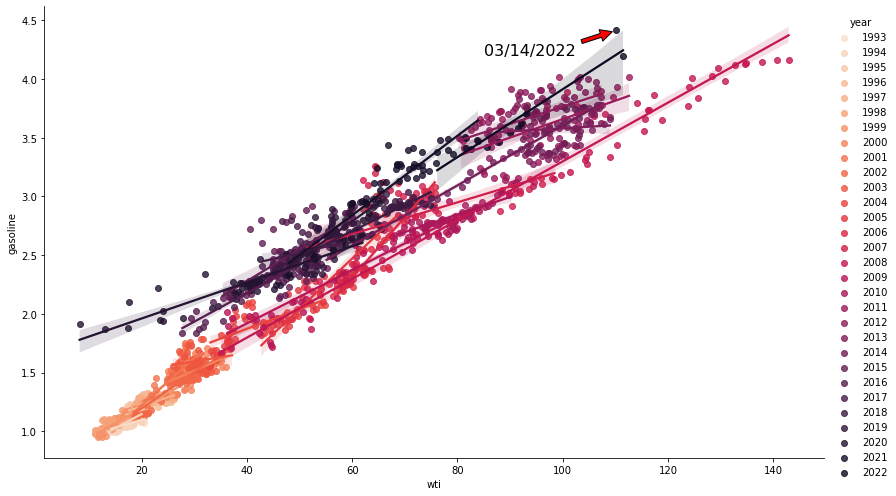

In [21]:
sns.lmplot(data=df, x='wti', y='gasoline', hue='year', palette='rocket_r', height=7, aspect=1.667)
plt.annotate(last_date, xy=(xpos, ypos), xytext=(85, 4.2),
            arrowprops=dict(facecolor='red', shrink=0.1), size=16)
plt.savefig('wti vs gasoline by year fitted.png')

Added some fits by year to see how the most recent data trends with the current year. The most recent week is the highest gasoline price yet.

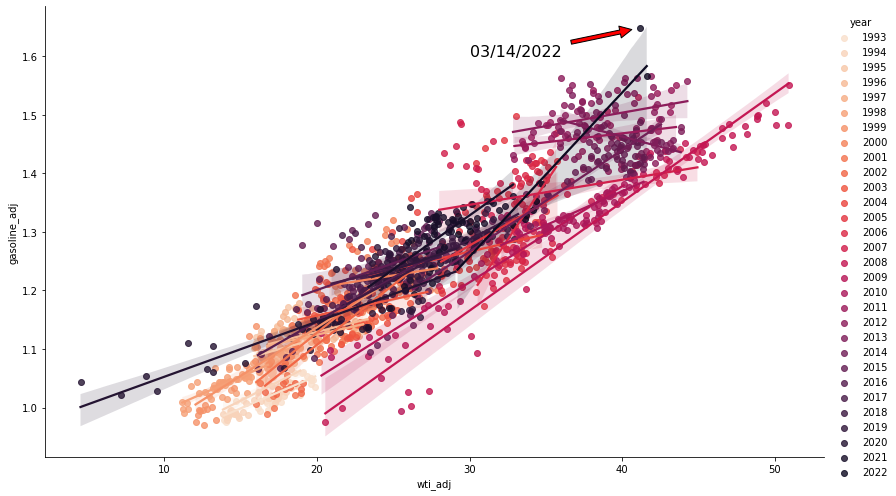

In [22]:
sns.lmplot(data=df, x='wti_adj', y='gasoline_adj', hue='year', palette='rocket_r', height=7, aspect=1.667)
plt.annotate(last_date, xy=(xpos_adj, ypos_adj), xytext=(30, 1.6),
            arrowprops=dict(facecolor='red', shrink=0.1), size=16)
plt.savefig('wti vs gasoline adjusted by year fitted.png')

Same plot but with inflation-adjusted values. This kind of smooshes all the years together and makes separation less apparent. That March point still looks like an outlier though.

Text(85, 175, '03/14/2022')

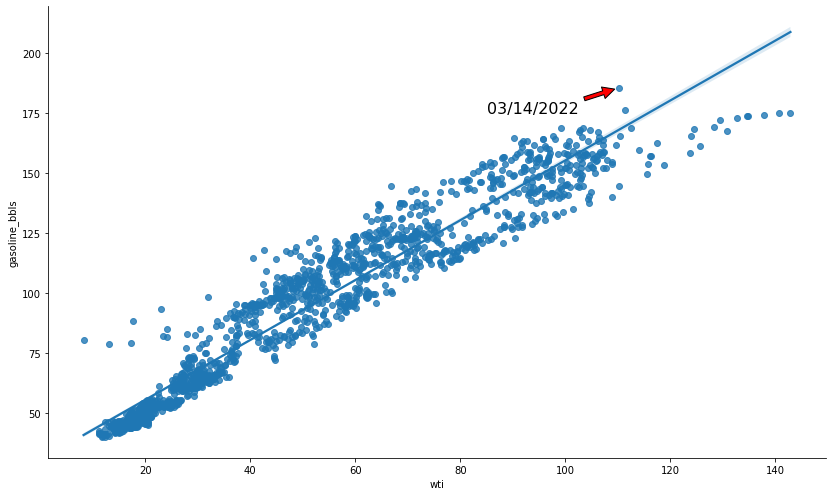

In [23]:
sns.lmplot(data=df, x='wti', y='gasoline_bbls', height=7, aspect=1.667)
plt.annotate(last_date, xy=(xpos, ypos_bbls), xytext=(85, 175),
            arrowprops=dict(facecolor='red', shrink=0.1), size=16)

Using gasoline in $/bbl vs oil price, we can fit a linear regresssion model. Looks pretty linear to me. Still think 3/14 is an outlier.

Text(30, 68, '03/14/2022')

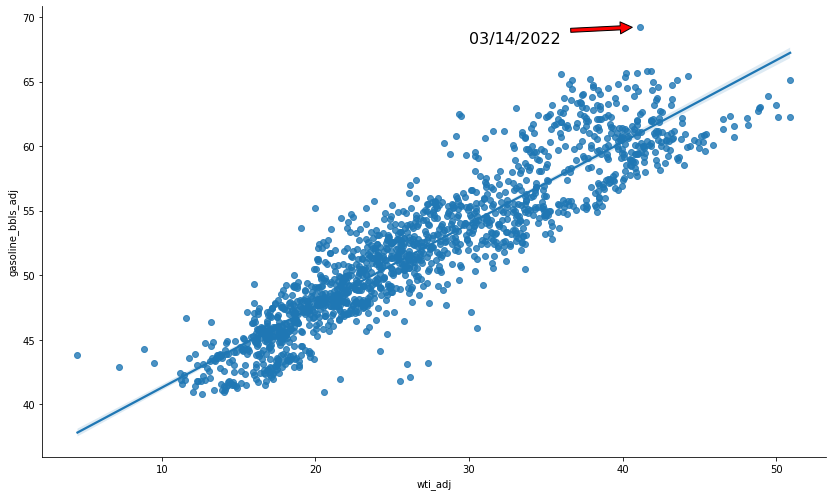

In [24]:
sns.lmplot(data=df, x='wti_adj', y='gasoline_bbls_adj', height=7, aspect=1.667)
plt.annotate(last_date, xy=(xpos_adj, ypos_bbls_adj), xytext=(30, 68),
            arrowprops=dict(facecolor='red', shrink=0.1), size=16)

Adjusting for inflation makes the plot noisier, but there is still a clear linear trend, and the point in question still stands out.

### Let's be more rigorous and use a Markov chain Monte Carlo simulation to estimate the posterior distributions.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, intercept, slope]
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:08<00:00, 4805.66draws/s]
The acceptance probability does not match the target. It is 0.8852297619479799, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9177083558944718, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the ta

array([[<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>],
       [<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'error'}>,
        <AxesSubplot:title={'center':'error'}>]], dtype=object)

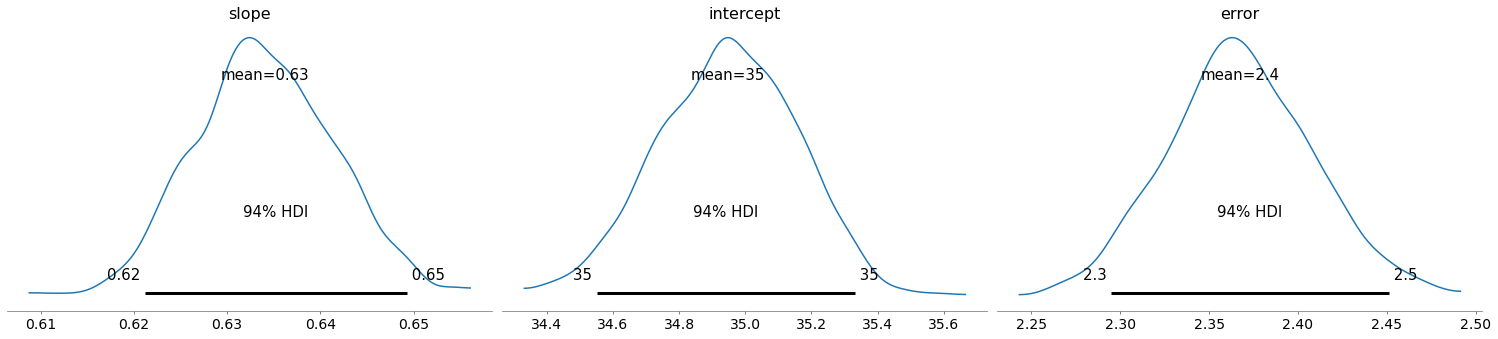

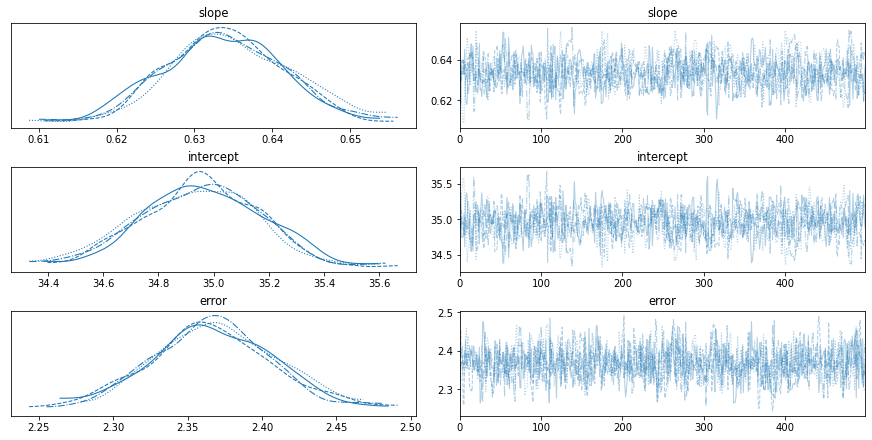

In [25]:
X = df.wti_adj
y = df.gasoline_bbls_adj

with pm.Model() as model:
    b1 = pm.Normal('slope', 0, 100)
    b0 = pm.Normal('intercept', 0, 100)
    s = pm.Exponential('error', 1)
    x_ = pm.Data('features', X)

    obs = pm.Normal('observation', b1*x_ + b0, s, observed=y)
    
    trace = pm.sample(tune=10000)
    
az.plot_posterior(trace)
az.plot_trace(trace)

Lastly, we can use the probabilistic model to predict values and generate bands of uncertainty.

100%|██████████| 2000/2000 [00:01<00:00, 1757.56it/s]


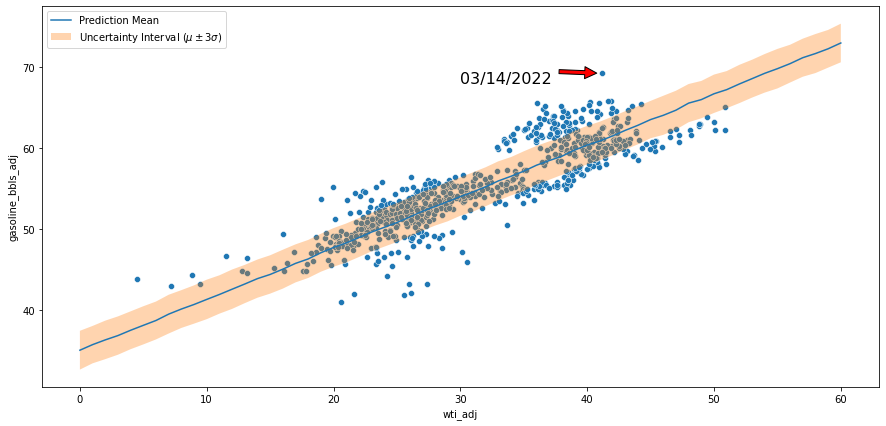

In [26]:
x_new = np.linspace(0,60,61)
with model:
    pm.set_data({'features': x_new})
    posterior = pm.sample_posterior_predictive(trace)

y_pred = posterior['observation']
y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(axis=0)

fig, ax = plt.subplots(figsize=(15,7))
sns.scatterplot(data=df[df.year>=2008], x='wti_adj', y='gasoline_bbls_adj')
plt.plot(x_new, y_mean, label='Prediction Mean')
plt.fill_between(x_new, y_mean - 1*y_std, y_mean + 1*y_std, alpha=0.33, label='Uncertainty Interval ($\mu\pm3\sigma$)')
plt.annotate(last_date, xy=(xpos_adj, ypos_bbls_adj), xytext=(30, 68),
            arrowprops=dict(facecolor='red', shrink=0.1), size=16)
plt.legend(loc='upper left')
plt.savefig('predicted wti vs gasoline.png')

One standard deviation around the mean.

100%|██████████| 2000/2000 [00:01<00:00, 1802.46it/s]


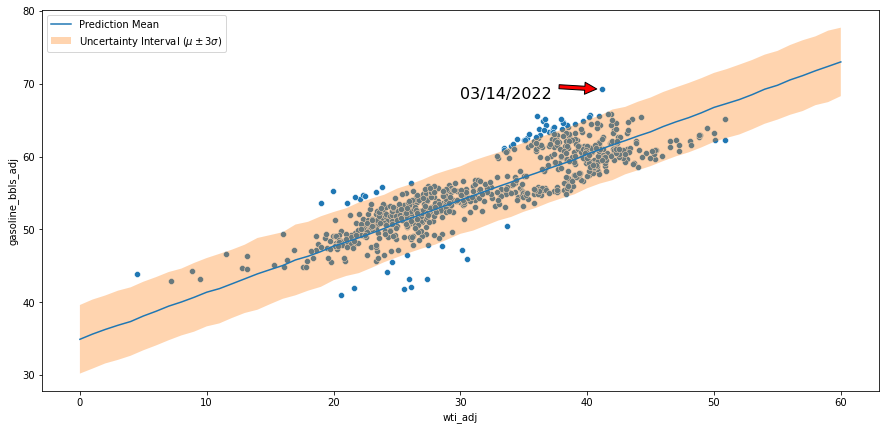

In [27]:
x_new = np.linspace(0,60,61)
with model:
    pm.set_data({'features': x_new})
    posterior = pm.sample_posterior_predictive(trace)

y_pred = posterior['observation']
y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(axis=0)

fig, ax = plt.subplots(figsize=(15,7))
sns.scatterplot(data=df[df.year>=2008], x='wti_adj', y='gasoline_bbls_adj')
plt.plot(x_new, y_mean, label='Prediction Mean')
plt.fill_between(x_new, y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.33, label='Uncertainty Interval ($\mu\pm3\sigma$)')
plt.annotate(last_date, xy=(xpos_adj, ypos_bbls_adj), xytext=(30, 68),
            arrowprops=dict(facecolor='red', shrink=0.1), size=16)
plt.legend(loc='upper left')
plt.savefig('predicted wti vs gasoline.png')

Two standard deviations around the mean.

100%|██████████| 2000/2000 [00:01<00:00, 1736.91it/s]


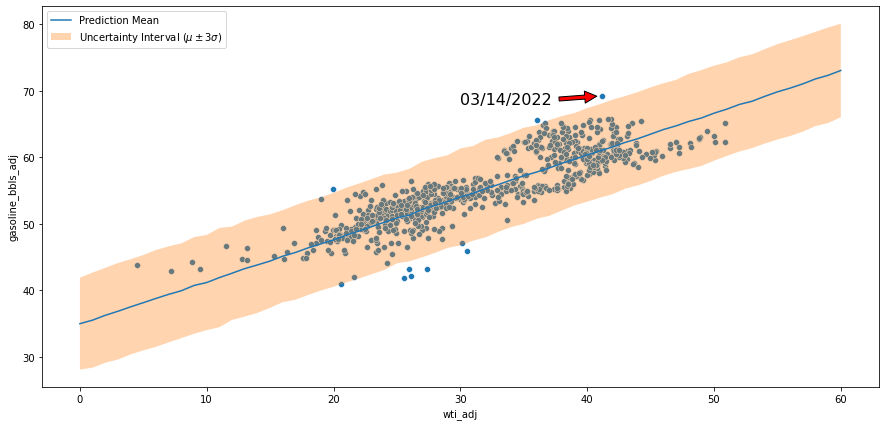

In [28]:
x_new = np.linspace(0,60,61)
with model:
    pm.set_data({'features': x_new})
    posterior = pm.sample_posterior_predictive(trace)

y_pred = posterior['observation']
y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(axis=0)

fig, ax = plt.subplots(figsize=(15,7))
sns.scatterplot(data=df[df.year>=2008], x='wti_adj', y='gasoline_bbls_adj')
plt.plot(x_new, y_mean, label='Prediction Mean')
plt.fill_between(x_new, y_mean - 3*y_std, y_mean + 3*y_std, alpha=0.33, label='Uncertainty Interval ($\mu\pm3\sigma$)')
plt.annotate(last_date, xy=(xpos_adj, ypos_bbls_adj), xytext=(30, 68),
            arrowprops=dict(facecolor='red', shrink=0.1), size=16)
plt.legend(loc='upper left')
plt.savefig('predicted wti vs gasoline.png')

Three standard deviations around the mean. I think it is fair to say that the past week was maybe a little bit of price gouging based on historical trends.

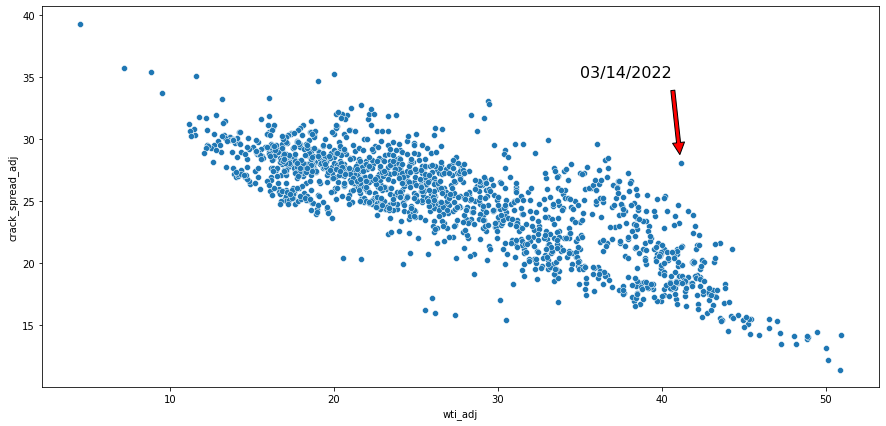

In [29]:
fig, ax = plt.subplots(figsize=(15,7))
sns.scatterplot(data=df, x='wti_adj', y='crack_spread_adj')
plt.annotate(last_date, xy=(xpos_adj, ypos_cs_adj), xytext=(35, 35),
            arrowprops=dict(facecolor='red', shrink=0.1), size=16)
plt.savefig('crack spread vs wti inflation-adjusted.png')

Another way to look at it is to plot the crack spread vs oil price.

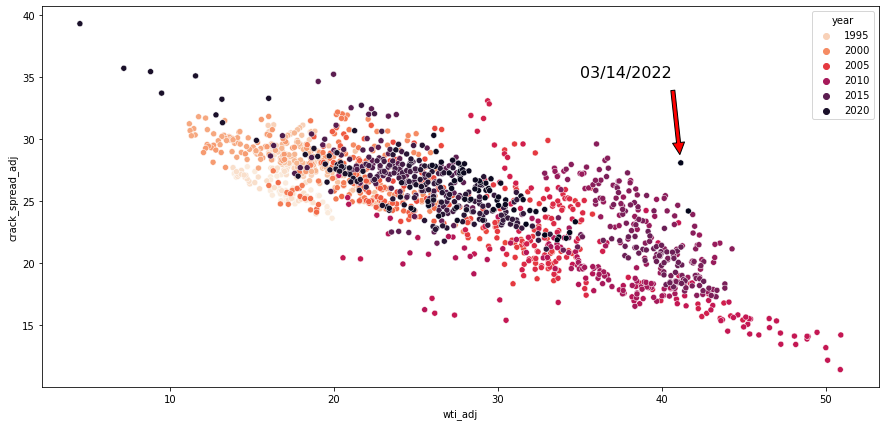

In [30]:
fig, ax = plt.subplots(figsize=(15,7))
sns.scatterplot(data=df, x='wti_adj', y='crack_spread_adj', hue='year', palette='rocket_r')
plt.annotate(last_date, xy=(xpos_adj, ypos_cs_adj), xytext=(35, 35),
            arrowprops=dict(facecolor='red', shrink=0.1), size=16)
plt.savefig('crack spread vs wti by year inflation-adjusted.png')

The crack spread reduces with higher oil prices. This could make intuitive sense. At lower prices, the impact of a higher price point on gasoline is not as meaningful to the average consumer. Additionally, refiners and suppliers are likely trying to maintain profitability with declining commodity prices.